# Derive terrain attributes from a Digital Elevation Model (DEM)

## Description
The purpose of this notebook is to compute terrain attributes from a Digital Elevation Model (DEM) for a specific area of interest. These terrain attributes provide important information about the topographic characteristics of the landscape and are particularly useful for studying wetlands. The notebook calculates various terrain indices such as aspect, curvature, Topographic Wetness Index (TWI), Terrain Profile Index (TPI), and Depth-to-Water. These indices offer insights into slope, orientation, shape, hydrology, water flow patterns, and other factors relevant to wetlands. By deriving these terrain attributes, researchers and analysts can better understand wetland dynamics, assess habitats, model ecosystems, and plan conservation strategies. The resulting terrain indices enhance wetland mapping, classification, and analysis, facilitating more accurate and detailed studies related to wetland ecosystems.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Inastall and load packages" cell.

## Install and load Packages

### Optional - Install onetime

In [1]:
# !pip install richdem
# !pip install focal_stats

In [2]:
%matplotlib inline

import os
import time
import math
import datacube
import rasterio
import rioxarray
import numpy as np
import xarray as xr
import xarray as xr
import richdem as rd
import rasterio as rio
import geopandas as gpd
from xrspatial import focal
from xrspatial import hillshade
import matplotlib.pyplot as plt
from xrspatial import convolution
from datacube.utils import geometry
from odc.dscache.tools import tiling
from datacube.utils.cog import write_cog
from scipy.ndimage import generic_filter
from datacube.utils.geometry import Geometry
from datashader.transfer_functions import shade
from scipy.ndimage import label, distance_transform_edt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datacube.utils.geometry import BoundingBox, Geometry

from deafrica_tools.areaofinterest import define_area
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize, xr_vectorize
from deafrica_tools.plotting import map_shapefile, display_map


import warnings
warnings.filterwarnings("ignore")

### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [3]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:39545' processes=1 threads=4, memory=26.21 GiB>

### Initialize Datacube

In [4]:
dc = datacube.Datacube(app="DEM")

### Load vector and plot area of interest

In [5]:
# Specify a prefix to identify the area of interest in the saved outputs
# By assigning the desired prefix, you can easily identify the outputs associated with the specific area of interest.
prefix = "test"

# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat= -28.0409, lon=31.8829, buffer=0.1)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='data/aoi/Senegal.geojson')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

display_map(x=lon_range, y=lat_range)

### Explore the product names, resolution, and measurements

In [6]:
product_name = ['dem_srtm', 'dem_srtm_deriv']
resolution = (-30, 30)
measurements = 'elevation'
dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype  units   nodata aliases
product        measurement                                            
dem_srtm       elevation    elevation    int16  metre -32768.0     NaN
dem_srtm_deriv mrvbf            mrvbf    int16      1 -32768.0     NaN
               mrrtf            mrrtf    int16      1 -32768.0     NaN
               slope            slope  float32      1  -9999.0     NaN

### Set up reusable  query object 

In [7]:
dask_chunks = {'x': 2500, 'y': 2500}

# set up daatcube query object
query = {
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    "geopolygon": geopolygon,
    'dask_chunks': dask_chunks,
    'resampling': "bilinear"
}

### Derive terrain attributes

In [8]:
# Define the output directory
output_dir = os.path.join("data/terrain_attributes/", prefix)
print(output_dir)
# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Load the dem 30 m product
ds_elev = dc.load(product="dem_srtm", measurements='elevation',
                  **query).squeeze()
# Load the ds_deriv dataset
ds_deriv = dc.load(product="dem_srtm_deriv",
                   measurements=['mrvbf', 'mrrtf', 'slope'],
                   **query).squeeze()

data/terrain_attributes/test


### Clip the datasets to the shape of the area of interest
A geopolygon represents the bounds and not the actual shape because it is designed to represent the extent of the geographic feature being mapped, rather than the exact shape. In other words, the geopolygon is used to define the outer boundary of the area of interest, rather than the internal features and characteristics.

Clipping the data to the exact shape of the area of interest is important because it helps ensure that the data being used is relevant to the specific study area of interest. While a geopolygon provides information about the boundary of the geographic feature being represented, it does not necessarily reflect the exact shape or extent of the area of interest.

In [9]:
#Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=geopolygon_gdf,
                          da=ds_elev,
                          crs=ds_elev.crs)
#Mask the dataset to the rasterised area of interest
ds_elev = ds_elev.where(aoi_raster == 1)
ds_deriv = ds_deriv.where(aoi_raster == 1)

##### Fill DEM and export elevation to GeoTiff
The fill_depressions function aims to fill depressions (low points or sinks) in a Digital Elevation Model (DEM). The function iteratively raises the elevation of low points (depressions) in the DEM by setting them to the minimum value encountered so far, until no more depressions are detected. This process ensures that all local minima (sinks) are filled, resulting in a filled DEM where water would flow off instead of accumulating in depressions.

In [10]:
# Extract elevation data from the loaded dataset
dem = ds_elev.elevation

def fill_depressions(dem):
    # Perform depression filling using some morphological operations.
    filled_dem = dem.copy()
    while True:
        marker = filled_dem.min()
        filled_dem = np.maximum(dem, marker)
        labels, num_features = label(dem > filled_dem)
        if num_features == 0:
            break
        dem = np.maximum(dem, filled_dem)
    return filled_dem

filled_dem = fill_depressions(dem).compute()

# Save elevation to GeoTiff
elevation_path = os.path.join(output_dir, "Elevation.tif")
write_cog(filled_dem,fname=elevation_path, overwrite=True)

PosixPath('data/terrain_attributes/test/Elevation.tif')

##### Export DEM SRTM Derivatives - MrRTF and MrVBF
**Multi-resolution Valley Bottom Flatness (MrVBF)** identifies valley bottoms (areas of deposition). Zero values indicate erosional terrain and values ≥1 and indicate progressively larger areas of deposition.

**Multi-resolution Ridge Top Flatness (MrRTF)** is complementary to MrVBF, zero values indicate areas that are steep or low, and values ≥1 indicate progressively larger areas of high flat land.

In [11]:
mrrtf = ds_deriv.mrrtf.compute()
mrvbf = ds_deriv.mrvbf.compute()

write_cog(mrrtf, fname=f"{output_dir}/MrRTF.tif", overwrite=True)
write_cog(mrvbf, fname=f"{output_dir}/MrVBF.tif", overwrite=True)

PosixPath('data/terrain_attributes/test/MrVBF.tif')

#### Topographic Wetness Index
The ***Topographic Wetness Index (TWI)*** is a useful model to estimate where water will accumulate in an area with elevation differences. It is a function of slope and the upstream contributing area.

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
TWI GeoTIFF saved as data/terrain_attributes/test/TWI.tif



A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0214903====================== ] (99% - 0.0s - 1 threads)

A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 118231
p Calculating flow accumulation...
t Wall-time       = 0.0302161 s============== ] (99% - 0.0s - 1 threads)


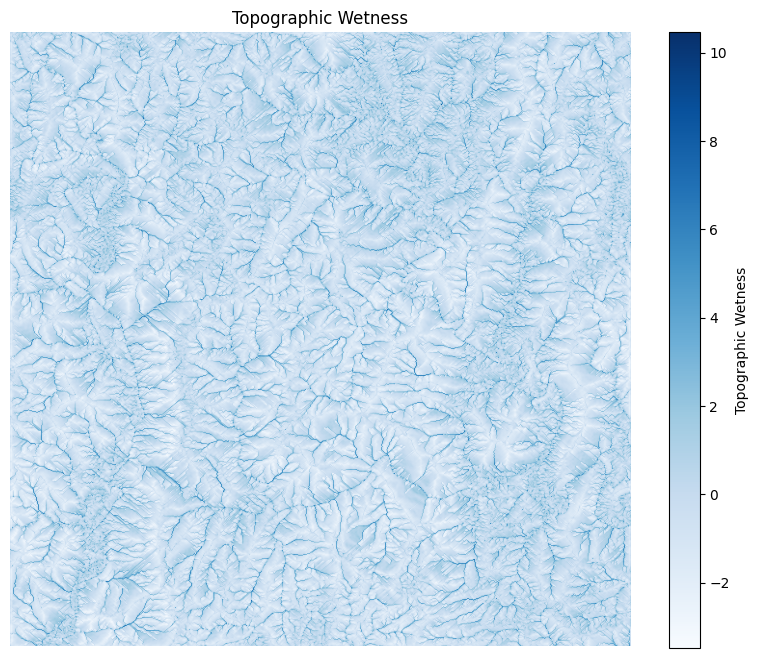

In [12]:
filled_dem_rd = rd.rdarray(filled_dem, no_data=-9999)

# Compute slope and flow accumulation
slope = rd.TerrainAttribute(filled_dem_rd, attrib='slope_radians')
accum_d8 = rd.FlowAccumulation(filled_dem_rd, method='D8')

# Compute Topographic Wetness Index (TWI)
twi = np.log(accum_d8 / (np.tan(slope) + 0.01)).astype(np.float32) # Convert TWI to float32

# Save TWI to GeoTIFF
output_file = f"{output_dir}/TWI.tif"
with rasterio.open(output_file, 'w', driver='GTiff', height=twi.shape[0],
                   width=twi.shape[1], count=1, dtype=str(twi.dtype),
                   crs=dem.geobox.crs, transform=dem.geobox.affine, nodata=-9999) as dst:
    dst.write(twi,1)

print(f"TWI GeoTIFF saved as {output_file}")

# Plotting TWI
plt.figure(figsize=(10, 8))
plt.imshow(twi, cmap='Blues', aspect='auto')
plt.colorbar(label='Topographic Wetness')
plt.title('Topographic Wetness')
plt.axis('off')
plt.show()


#### Depth to Water
The Depth-to-Water (DTW) index is a soil wetness indicator derived from a Digital Elevation Model (DEM). It calculates the least elevation difference between surface flow channels and surrounding landscape areas. The key points are:

* Surface Flow Channels as Reference: The DTW index considers surface flow channels, extracted from DEMs, as reference points representing the groundwater level.
* Calculation of DTW Values: DTW values are defined as zero at these surface flow channels. As you move away from these channels, the DTW values increase, reflecting greater depth to the water table and reduced soil wetness.
* Soil Wetness Indicator: A higher DTW value indicates that the area is further from surface water, suggesting lower soil moisture and drier conditions. Conversely, areas closer to surface water channels will have lower DTW values, indicating higher soil moisture.



The function calculates the DTW Index, which estimates the depth of surface water in meters based on the topographic characteristics of the terrain and the cost function for least-cost path calculation.
1. Calculates the threshold (t) for the minimal flow initiation area (FIA) based on the input parameter fia. The threshold represents how much area needs to accumulate downward the slope to result in a channel with simulated surface water. This step is necessary to determine which areas are likely to have surface water.
    * 0.25: This means that for water to start flowing, it needs to accumulate in an area of at least 0.25 hectares (2500 square meters).
    * 1: In this case, water needs to accumulate in an area of at least 1 hectare (10,000 square meters) to start flowing.
    * 4: Here, the required minimum area for water accumulation is 4 hectares (40,000 square meters).

2. Uses the calculated threshold to compare the flow accumulationto identify channels with surface water and sets them to 1 in the flowLines raster. Cells with flow accumulation below the threshold are marked as null. This step creates a binary raster layer where 1 represents channels with surface water, and null represents other areas.

3. Calculates the least-cost path of slope (cost) starting from the identified flow lines. This step helps determine the least costly path from each cell to the flow lines, considering the slope of the terrain. The cost raster will contain values representing the minimum height difference between each cell and the flow path.

4. Computes the Cartographic Depth-to-Water (DTW) Index in meters. The DTW raster is calculated by multiplying the cost raster by the spatial resolution of the DEM and dividing it by 100. This step converts the cost values (originally in percent) to represent the estimated depth of water in meters for each cell in the study area.


**References**
* [Using the Cartographic Depth-to-Water Index to Locate Small Streams and Associated Wet Areas across Landscapes](https://www.tandfonline.com/doi/full/10.4296/cwrj2011-909)
* [Evaluating the effect of DEM resolution on performance of cartographic depth-to-water maps, for planning logging operations](https://www.sciencedirect.com/science/article/pii/S030324342200054X)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 118231
p Calculating flow accumulation...
t Wall-time       = 0.0280212 s============== ] (99% - 0.0s - 1 threads)


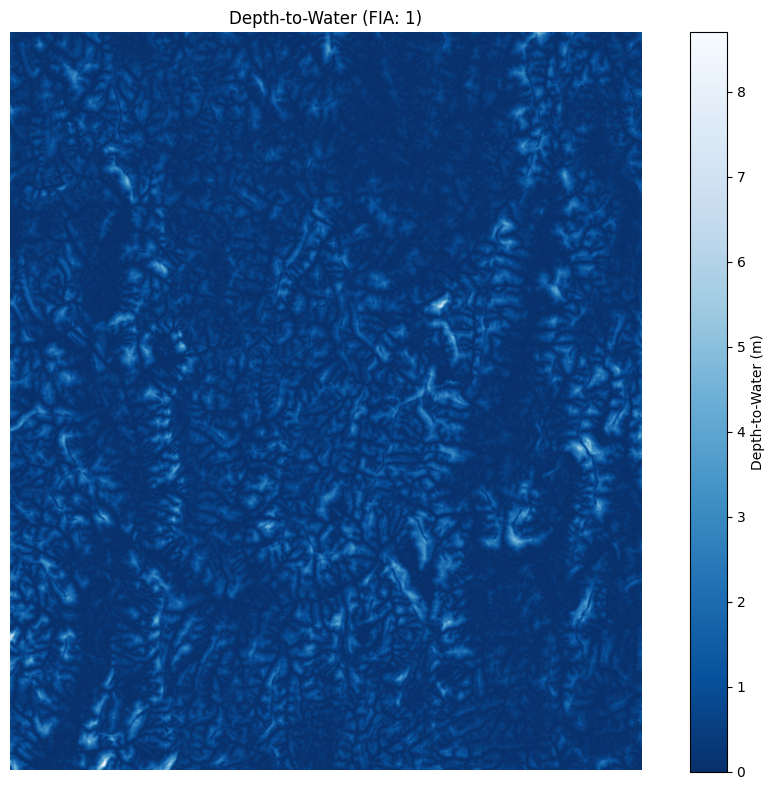

In [13]:
slope = ds_deriv.slope #Note slope is already in percent - from the SRTM pre calculated derivatives

# Set the FIA value you want to use
fia = 1

def calcDTW(fia, filled_dem, slope):
    # Step 1: Calculate the threshold for minimal flow initiation (t)
    t = fia * 10000 / (abs(resolution[0]) * abs(resolution[1]))  # Convert FIA from hectares to square meters
    
    # Step 2: Calculate flow accumulation and identify flow lines/channels
    filled_dem_rd = rd.rdarray(filled_dem, no_data=-9999)
    accum_d8 = rd.FlowAccumulation(filled_dem_rd, method='D8')
    # Create binary flow channels
    flow_lines = accum_d8 >= t

    # Step 3: Calculate the least-cost of slope in percentage starting from the flow line
    cost_distance = distance_transform_edt(~flow_lines)  # Use ~ to invert the binary mask

    # Step 4: Compute DTW in meters
    DTW = cost_distance * (slope / 100)  # slope is already in percentage
    
    return DTW

# Calculate and plot DTW for FIA value 1
dtw = calcDTW(fia, filled_dem, slope).compute().astype(np.float32)  # Convert DTW to float32

# Save the DTW result to a GeoTIFF file
output_file = f"{output_dir}/DTW.tif"
write_cog(dtw, fname=output_file, overwrite=True)

# Plot DTW
plt.figure(figsize=(10, 8))
im = plt.imshow(dtw, cmap='Blues_r')
plt.colorbar(label='Depth-to-Water (m)')
plt.title(f'Depth-to-Water (FIA: {fia})')
plt.axis('off')  
plt.tight_layout()
plt.show()

#### Derive multi-scale terrain indices
These include Slope, Curvature, Planform Curvature and Profile Curvature and Topographic Postion Index (TPI).

The ***Topographic Position Index (TPI)*** is a metric of slope position, based on the method of Weiss (2001) that corresponds to the difference of the elevation of a central pixel with the average of that of neighbouring pixels. Its unit is that of the DEM (typically meters) and it can be computed for any window size (default 3x3 pixels).

**Moving Window Approach**
The moving window approach involves sliding a defined window across the raster data to compute spatial metrics. The window size determines the extent of the neighbourhood around each pixel. As the window moves pixel by pixel, it calculates the metric (e.g., slope, curvature) based on the pixels within the window. The neighbourhood around each pixel is defined by one of three spatial contiguity matrices, namely, Queen's, Rook's and Bishop's case contiguity which are explained below. This approach allows for the calculation of local terrain indices that reflect the characteristics of each pixel relative to its surrounding area. The window size can be adjusted to capture different spatial scales and nuances in the terrain, providing flexibility in the analysis. Larger windows capture broader patterns, while smaller windows focus on more localised features.

**Queen's case contiguity**
* Definition: In the 'queen' method, a cell is considered contiguous if it shares an edge or a corner with the neighboring cell. This includes all eight surrounding cells.
* Matrix Representation: The xl_mat, xr_mat, yt_mat, and yb_mat matrices define connectivity by setting the entire edges of the window to 1, allowing diagonals to be considered as neighbors.
* Usage: This method captures more complex spatial relationships because it includes diagonal neighbors. It is often used when you want to include all potential neighbors, providing a more connected neighborhood.

**Rook's case contiguity**
* Definition: In the 'rook' method, a cell is considered contiguous only if it shares an edge with another cell, excluding diagonal neighbors. This means only the directly adjacent cells (up, down, left, right) are considered neighbors.
* Matrix Representation: The xl_mat, xr_mat, yt_mat, and yb_mat matrices define connectivity by setting only the central row or column on each edge to 1, excluding diagonals.
* Usage: This method is simpler and often used when you want to include only directly adjacent neighbors. It provides a less connected neighborhood compared to the 'queen' method but is simpler computationally.

**Bishop's case contiguity**

* Definition: In the 'bishop' method, a cell is considered contiguous if it shares a corner with another cell, similar to the movement of a bishop in chess. This includes only diagonal neighbors. Thus, a cell is connected to the four diagonal cells that surround it.
* Matrix Representation: The xl_mat, xr_mat, yt_mat, and yb_mat matrices define connectivity based on diagonal relationships. For the bishop contiguity, these matrices are filled to represent the diagonals, allowing cells connected diagonally to be included.
* Usage: This method captures relationships that involve diagonal connections, excluding the directly adjacent cells. It provides a neighborhood that connects cells diagonally, which can be useful for certain spatial analyses where diagonal connections are more relevant than edge-sharing ones.



**Depending on the size of the area, this process will take some time.**

Processing window size: (3, 3)


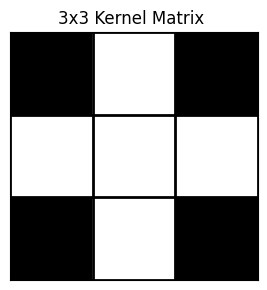

Calculating slope...
Calculating curvature...
Calculating profile curvature...
Calculating planform curvature...
Calculating TPI...
Focal Mean: 0m 17.86s
Gradient: 0m 0.00s
Slope Calculation: 0m 0.00s
Curvature: 0m 0.00s
Profile Curvature: 0m 0.01s
Planform Curvature: 0m 0.00s
TPI: 0m 17.86s
All terrain indices for window size (3, 3) saved to data/terrain_attributes/test
Completed window size: (3, 3) in 1m 48.00s
Processing window size: (15, 15)


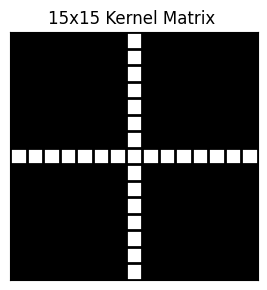

Calculating slope...
Calculating curvature...
Calculating profile curvature...
Calculating planform curvature...
Calculating TPI...
Focal Mean: 0m 18.58s
Gradient: 0m 0.00s
Slope Calculation: 0m 0.00s
Curvature: 0m 0.00s
Profile Curvature: 0m 0.01s
Planform Curvature: 0m 0.00s
TPI: 0m 18.45s
All terrain indices for window size (15, 15) saved to data/terrain_attributes/test
Completed window size: (15, 15) in 1m 51.92s
Processing window size: (25, 25)


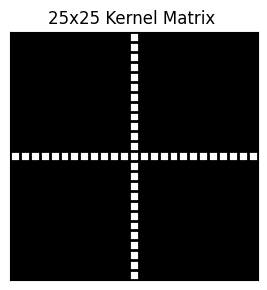

Calculating slope...
Calculating curvature...
Calculating profile curvature...
Calculating planform curvature...
Calculating TPI...
Focal Mean: 0m 19.10s
Gradient: 0m 0.00s
Slope Calculation: 0m 0.00s
Curvature: 0m 0.00s
Profile Curvature: 0m 0.00s
Planform Curvature: 0m 0.00s
TPI: 0m 19.19s
All terrain indices for window size (25, 25) saved to data/terrain_attributes/test
Completed window size: (25, 25) in 1m 56.06s
Processing window size: (37, 37)


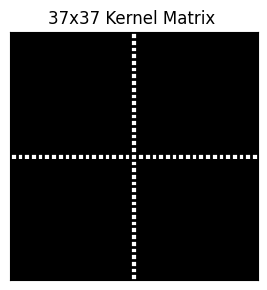

Calculating slope...
Calculating curvature...
Calculating profile curvature...
Calculating planform curvature...
Calculating TPI...
Focal Mean: 0m 20.07s
Gradient: 0m 0.00s
Slope Calculation: 0m 0.00s
Curvature: 0m 0.00s
Profile Curvature: 0m 0.01s
Planform Curvature: 0m 0.00s
TPI: 0m 19.87s
All terrain indices for window size (37, 37) saved to data/terrain_attributes/test
Completed window size: (37, 37) in 2m 0.01s


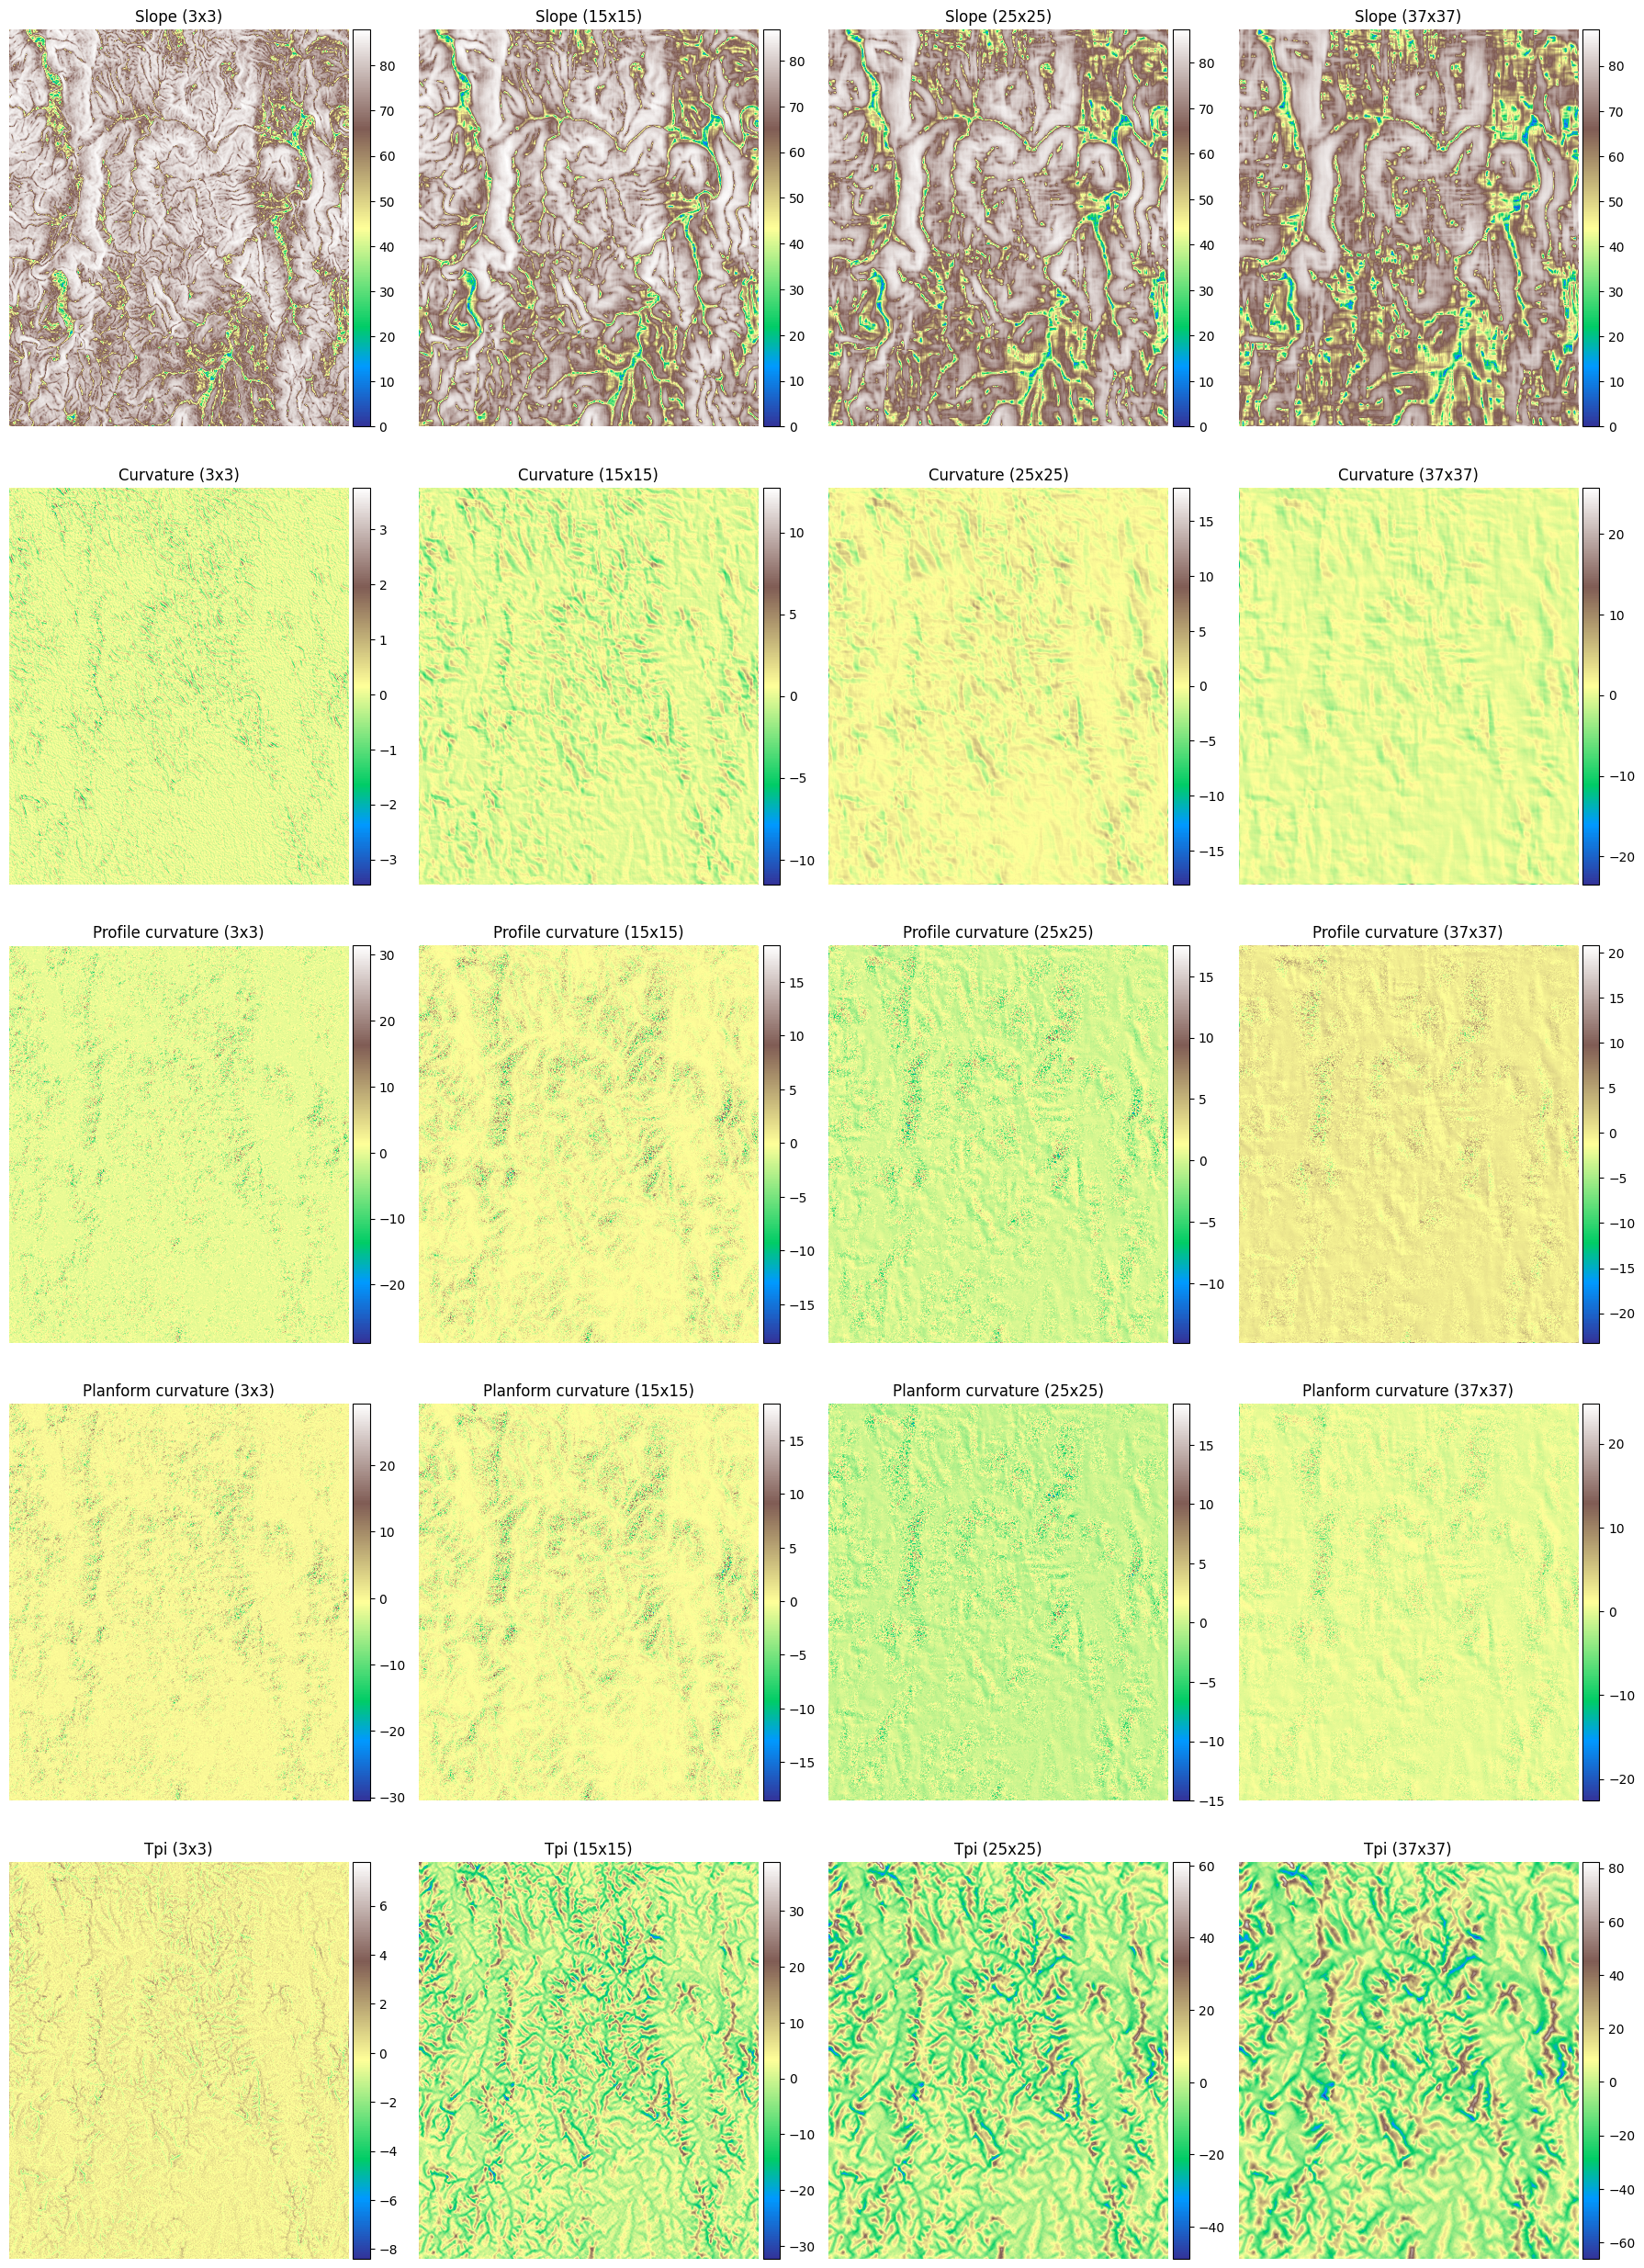

In [14]:
def terrain_indices(filled_dem, w=(3, 3), unit='degrees', method='rook'):
    if filled_dem.shape[0] < 3 or filled_dem.shape[1] < 3:
        raise ValueError("Input filled_dem must have at least 3 rows and 3 columns")
    
    # Ensure window size is odd
    kx, ky = w
    if kx % 2 == 0 or ky % 2 == 0:
        raise ValueError("Window dimensions must be odd numbers")
    
    # Define padding sizes
    pad_width = ((ky // 2, ky // 2), (kx // 2, kx // 2))
    
    # Pad the input array with NaNs
    # Padding is applied to the filled_dem array to prevent edge effects during the calculation of terrain indices.
    # By adding a layer of NaNs around the edges, we ensure that the moving window can compute values for all cells,
    # including those on the borders. This helps maintain the original dimensions of the output while 
    # allowing the computations to consider surrounding cells without running into index errors.
    padded_dem = np.pad(filled_dem, pad_width, mode='constant', constant_values=np.nan)

    # Create matrices based on the chosen method
    kernel = np.zeros((ky, kx))
    jy, jx = (ky // 2), (kx // 2)

    if method == 'queen':
        kernel[:] = 1
    elif method == 'rook':
        kernel[jy, :] = 1  # Horizontal row
        kernel[:, jx] = 1  # Vertical column
    elif method == 'bishop':
        for i in range(ky):
            for j in range(kx):
                if abs(i - jy) == abs(j - jx):  # Diagonal check
                    kernel[i, j] = 1
                    
                    
    # Function to visualize the kernel
    def plot_single_kernel(kernel, window_size):
        fig, ax = plt.subplots(figsize=(3, 3))

        ax.imshow(kernel, cmap='gray', interpolation='nearest', vmin=0, vmax=1)

        ax.set_xticks(np.arange(kernel.shape[1] + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(kernel.shape[0] + 1) - 0.5, minor=True)

        ax.grid(which="minor", color='black', linestyle='-', linewidth=2)
        ax.tick_params(which="minor", size=0)
        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_title(f"{window_size[0]}x{window_size[1]} Kernel Matrix ")
        plt.tight_layout()
        plt.show()

    plot_single_kernel(kernel, w)                

    def focal_mean(arr, kernel):
        return generic_filter(arr, np.nanmean, footprint=kernel, mode='constant', cval=np.nan)

    # Initialize a dictionary to store computation times
    computation_times = {}
    
    # Smooth the DEM using focal mean
    start_time = time.time()
    smoothed_dem = focal_mean(padded_dem, kernel)
    computation_times['Focal Mean'] = time.time() - start_time

    # Calculate the gradient of the smoothed DEM
    start_time = time.time()
    dz_dx, dz_dy = np.gradient(smoothed_dem)
    computation_times['Gradient'] = time.time() - start_time

    print("Calculating slope...")
    start_time = time.time()
    slope_k = np.arctan(np.sqrt(dz_dx ** 2 + dz_dy ** 2))  # Use direct gradients
    if unit == 'degrees':
        slope_k = np.degrees(slope_k)
    computation_times['Slope Calculation'] = time.time() - start_time

    aspect_k = (-np.pi / 2) - np.arctan2(dz_dy, dz_dx)
    aspect_k = np.where(aspect_k < 0, aspect_k + 2 * np.pi, aspect_k)
    if unit == 'degrees':
        aspect_k = np.degrees(aspect_k)

    # Calculate second derivatives using focal mean
    dz2_dx2 = focal_mean(dz_dx, kernel) - dz_dx 
    dz2_dy2 = focal_mean(dz_dy, kernel) - dz_dy
    dz2_dxdy = focal_mean(dz_dx, kernel) - focal_mean(dz_dy, kernel)

    print("Calculating curvature...")
    start_time = time.time()
    curvature_k = dz2_dx2 + dz2_dy2
    computation_times['Curvature'] = time.time() - start_time
    
    print("Calculating profile curvature...")
    start_time = time.time()
    profile_curvature_k = dz2_dy2 * np.cos(aspect_k)**2 + dz2_dx2 * np.sin(aspect_k)**2 + 2 * dz2_dxdy * np.sin(aspect_k) * np.cos(aspect_k)
    computation_times['Profile Curvature'] = time.time() - start_time
    
    print("Calculating planform curvature...")
    start_time = time.time()
    planform_curvature_k = dz2_dy2 * np.sin(aspect_k)**2 + dz2_dx2 * np.cos(aspect_k)**2 - 2 * dz2_dxdy * np.sin(aspect_k) * np.cos(aspect_k)
    computation_times['Planform Curvature'] = time.time() - start_time

    print("Calculating TPI...")
    start_time = time.time()
    focal_mean_including_center = focal_mean(padded_dem, kernel)
    tpi_k = padded_dem - focal_mean_including_center
    computation_times['TPI'] = time.time() - start_time

    # Print computation times for each terrain index
    for metric, elapsed in computation_times.items():
        minutes, seconds = divmod(elapsed, 60)
        print(f"{metric}: {int(minutes)}m {seconds:.2f}s")
    
    # Return results with original shape
    result = {}
    metrics = ['Slope', 'Curvature', 'Profile_curvature', 'Planform_curvature', 'TPI']
    for metric in metrics:
        result[metric] = locals()[f'{metric.lower()}_k'][pad_width[0][0]:-pad_width[0][1], pad_width[1][0]:-pad_width[1][1]]

    return result, w

# Convert numpy array to xarray DataArray
def array_to_dataarray(array, filled_dem, metric):
    return xr.DataArray(
        array,
        dims=["y", "x"],
        coords={"y": filled_dem.coords["y"], "x": filled_dem.coords["x"]},
        attrs={"crs": filled_dem.attrs["crs"], "nodata": filled_dem.attrs.get("nodata", None)}
    ).rename(metric)

# Define the window sizes and start timing the overall process
window_sizes = [(3, 3), (15, 15), (25, 25), (37, 37)]
data = {}

for w in window_sizes:
    print(f'Processing window size: {w}')
    start_time = time.time()  # Start overall timing for this window size

    # Calculate terrain indices for this window size
    results, _ = terrain_indices(filled_dem, w=w)

    for metric, result in results.items():
        # Store the result for later plotting
        if metric not in data:
            data[metric] = {}
        data[metric][w] = result

        # Convert numpy array to xarray DataArray
        result_da = array_to_dataarray(result, filled_dem, metric).astype(np.float32)

        # Save the terrain indices to GeoTIFF
        output_filename = f"{output_dir}/{metric}_{30 * w[0]}m.tif"
        try:
            write_cog(result_da, fname=output_filename, overwrite=True)
        except Exception as e:
            print(f"Error saving {output_filename}: {e}")
            
    # Print a single summary message for all saved files after the loop
    print(f"All terrain indices for window size {w} saved to {output_dir}")
    elapsed_time = time.time() - start_time  # End overall timing
    minutes, seconds = divmod(elapsed_time, 60)
    print(f'Completed window size: {w} in {int(minutes)}m {seconds:.2f}s')

# Prepare subplots for plotting
fig, axes = plt.subplots(len(data), len(window_sizes), figsize=(18, 5 * len(data)))

# Plot all the metrics for each window size
for i, (metric, windows_data) in enumerate(data.items()):
    for j, w in enumerate(window_sizes):
        result = windows_data[w]

        # Create subplot
        ax = axes[i, j] if len(window_sizes) > 1 else axes[j]
        im = ax.imshow(result, cmap='terrain', origin='lower')

        # Create a divider for the existing axes and append a color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # Add color bar
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=10)  # Adjust colorbar tick size if needed
        
        ax.set_title(f'{metric.capitalize()} ({w[0]}x{w[1]})'.replace('_', ' '))
        ax.axis('off')

plt.tight_layout()
plt.show()


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [15]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2024-10-01'